# Analisis Predictivo de Series Temporales

## Curso 2022 - Universidad ORT Uruguay

## Parcial - Fecha 12/12

### Nombre del estudiante: [completar]

In [ ]:
## Ejemplo: instalación de astsadata usando pip:
#!pip install astsadata

## Ajusto tamaño de figuras
import matplotlib.pyplot as plt
import astsadata as astsa
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import scipy as sp
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ARIMA

plt.rcParams['figure.figsize'] = [15,5]
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
def periodogram(x,sampling_frequency=1):

    """Función que calcula el periodograma y grafica.
    
    Parameters
    ----------
        x : array_like, data.
        sampling_frequency: frecuencia de muestreo de la serie, para graficar.
    """

    n = x.size
    P = 4/n**2 * np.abs(np.fft.fft(x))**2
    P = P[0:round(n/2)]
    f = np.arange(0,round(n/2))/n * sampling_frequency
    plt.plot(f,P);
    plt.xlabel("Frequency")
    plt.ylabel("Power")

In [3]:
def spectrum(x,sampling_frequency=1, nfreq=10):

    """Función que calcula las componentes más relevantes del periodograma.
    
    Parameters
    ----------
        x : array_like, data.
        sampling_frequency: frecuencia de muestreo de la serie, para graficar.
    """

    n = x.size
    nfreq = np.minimum(nfreq,round(n/2)) #corto nfreq si la serie es muy corta!
    P = 4/n**2 * np.abs(np.fft.fft(x))**2
    P = P[0:round(n/2)]
    f = np.arange(0,round(n/2))/n * sampling_frequency
    index = np.argsort(P)[::-1] #ordeno P decreciente
    return pd.DataFrame({"Frecuencia" : f[index[0:nfreq]],"Potencia" : P[index[0:nfreq]]})

### Ejercicio 1

Se considera la serie `cardox` de la biblioteca `astsa`, que registra los niveles de $CO_2$ en el observatorio de Mauna Loa, Hawaii. La misma se grafica abajo.

1. Realizar un ajuste de tendencia lineal para la serie. Discutir el resultado.
2. Agregar un término de tendencia cuadrática $x = \beta_0 + \beta_1 t + \beta_2 t^2 + w_t$ y discutir si mejora respecto al anterior.
3. Realizar un periodograma de los residuos para encontrar componentes estacionales (por ej. anuales).
4. Incluir en la regresión tanto los términos de tendencia como estacionales que considere adecuados y realizar el ajuste.
5. Discutir los residuos obtenidos. ¿Queda información por extraer? (No se pide realizar más ajustes)

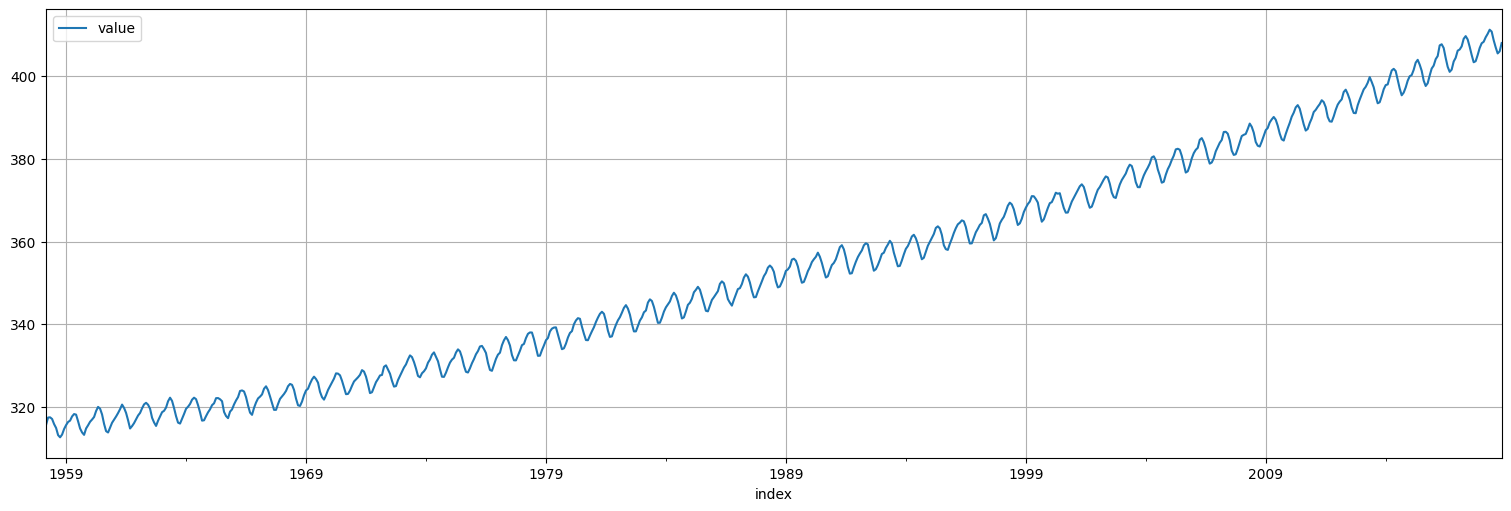

In [4]:
cardox = astsa.cardox
cardox.plot();

In [5]:
cardox.head()

,value
index,
1958-03,315.71
1958-04,317.45
1958-05,317.50
1958-06,317.10
1958-07,315.86


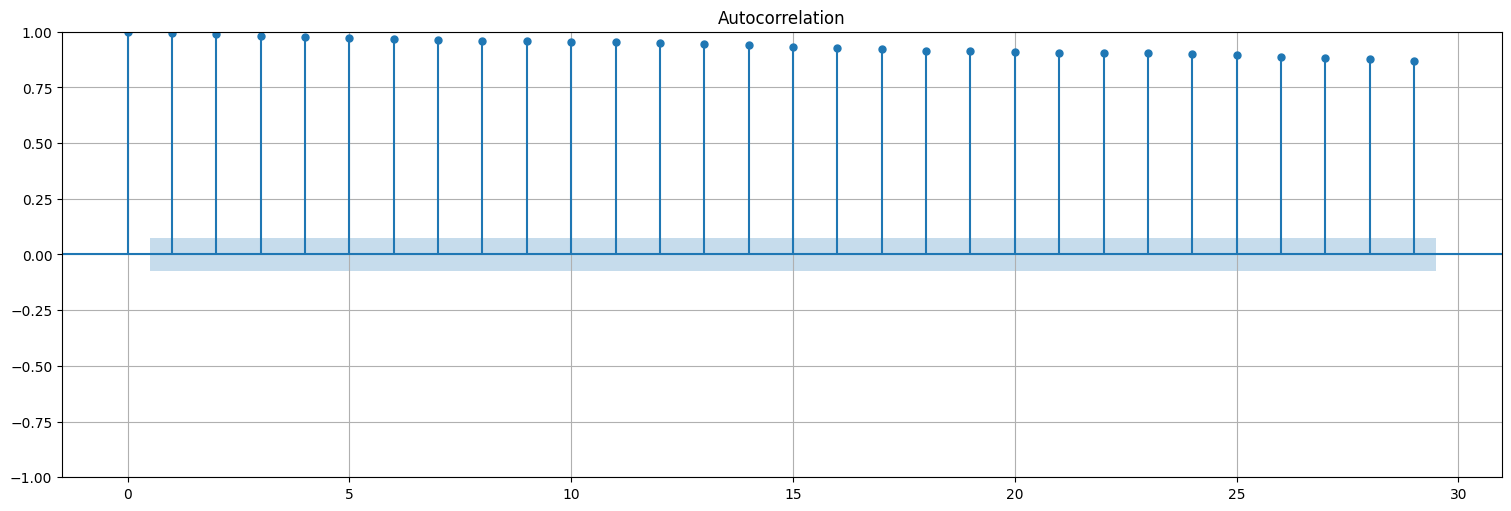

In [6]:
plot_acf(cardox,bartlett_confint=False);

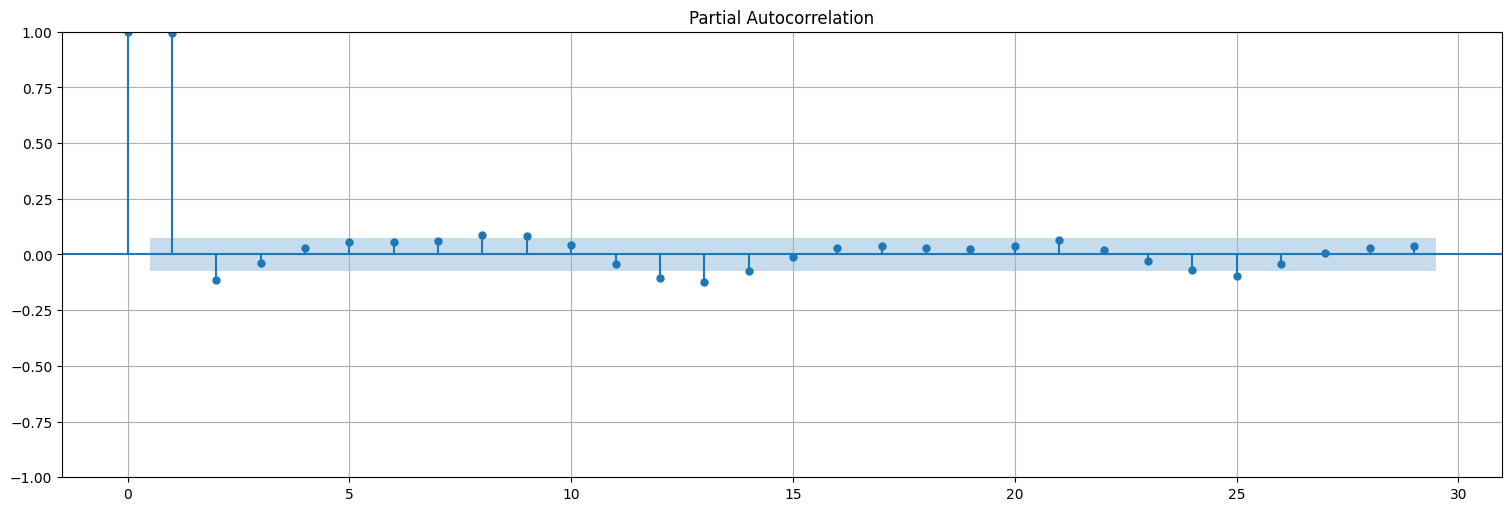

In [7]:
plot_pacf(cardox);

Parte 1

In [8]:
time = pd.Series([idx.ordinal for idx in cardox.index],index=cardox.index)
data = pd.concat([cardox,time],axis=1)
data.columns = ["cardox","time"]
cardoxfit_linear = smf.ols(formula="cardox ~ time", data=data).fit()
cardoxfit_linear_resid = cardoxfit_linear.resid
cardoxfit_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cardox   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 3.168e+04
Date:                Mon, 01 Jul 2024   Prob (F-statistic):               0.00
Time:                        18:08:57   Log-Likelihood:                -2067.2
No. Observations:                 729   AIC:                             4138.
Df Residuals:                     727   BIC:                             4148.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    325.0746      0.222   1462.357      0.000     324.638     325.511
time           0.1293      0.001    177.976      0.000       0.128       0.131
==============================================================================
Omnibus:                       33.937   Durbin-Watson:                   0.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.757
Skew:                           0.532   Prob(JB):                     1.04e-08
Kurtosis:                       2.720   Cond. No.                         445.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

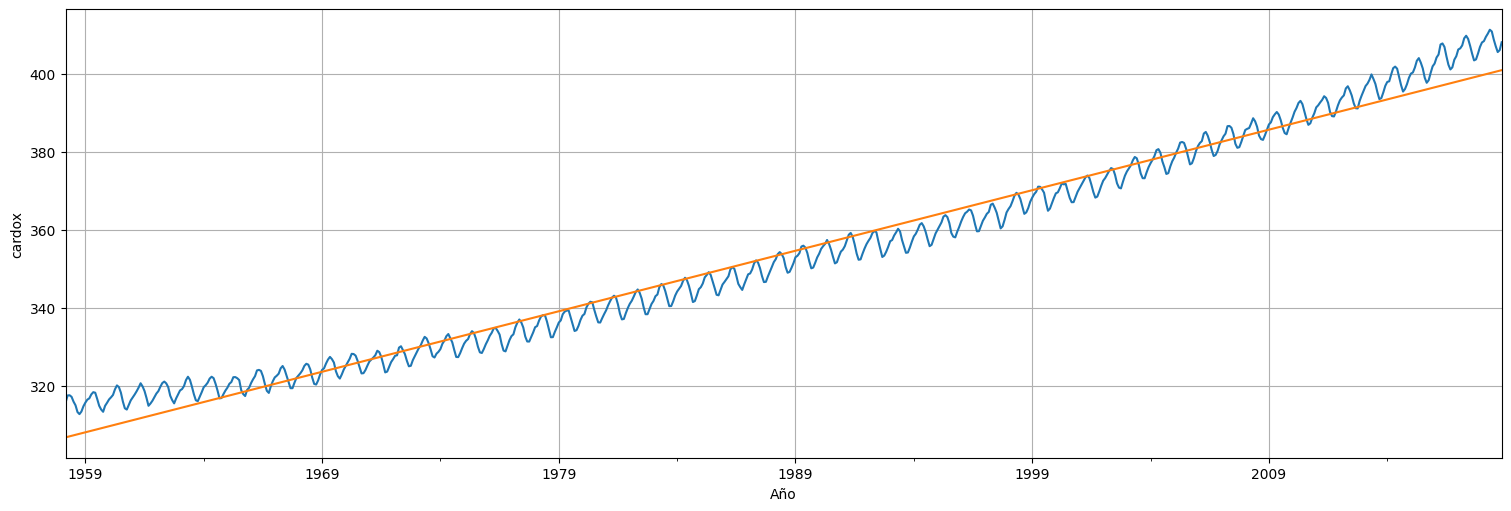

In [9]:
ax = cardox.plot(xlabel="Año", ylabel="cardox", legend=False)
ax.plot(cardoxfit_linear.fittedvalues);

In [ ]:
Hay una tendencia significativa ya que el p-valor es prácticamente 0 (y de esta forma se rechaza la hipótesis nula).
Aumenta en promedio 12% mensual

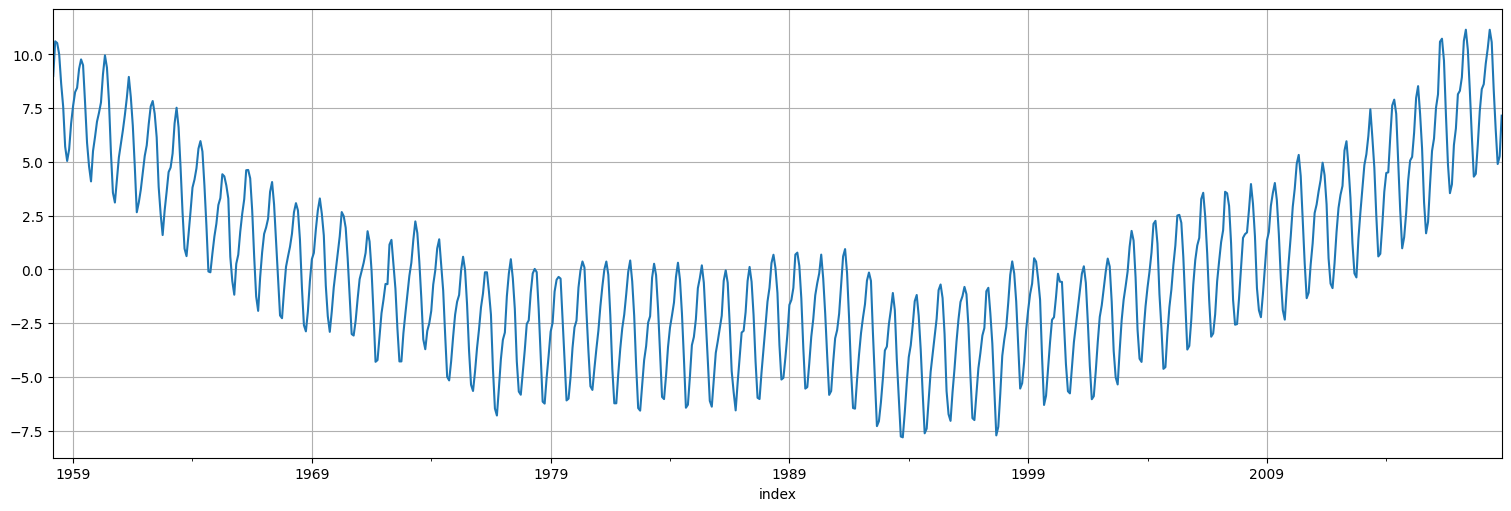

In [10]:
cardoxfit_linear_resid.plot();

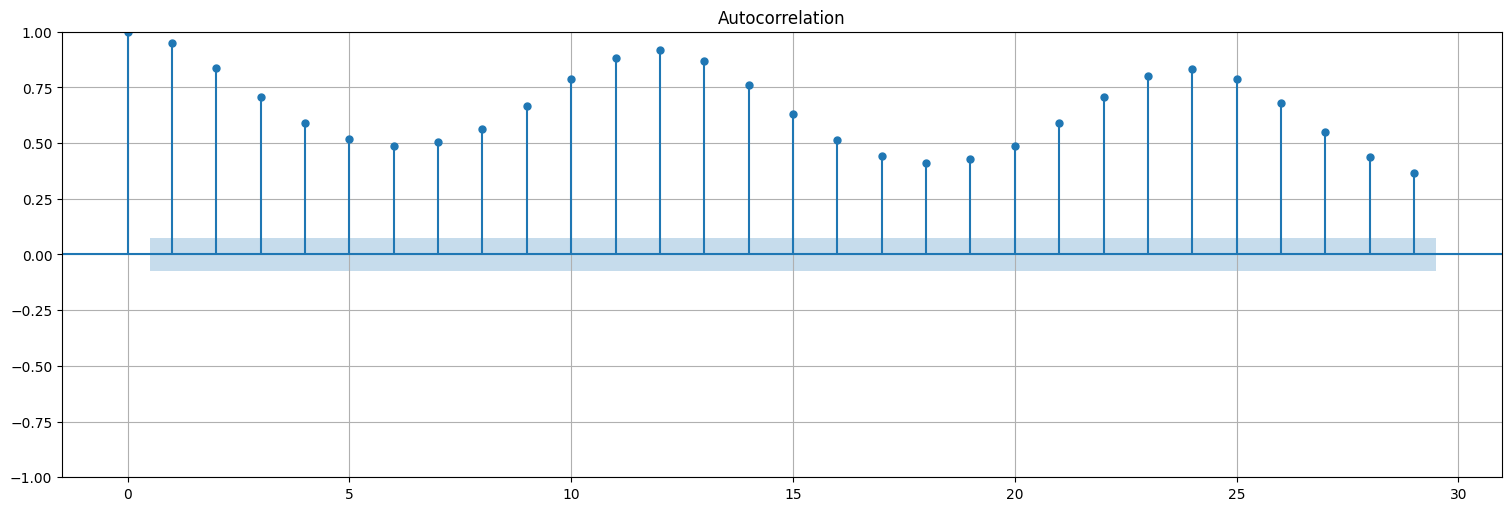

In [11]:
plot_acf(cardoxfit_linear_resid,bartlett_confint=False);

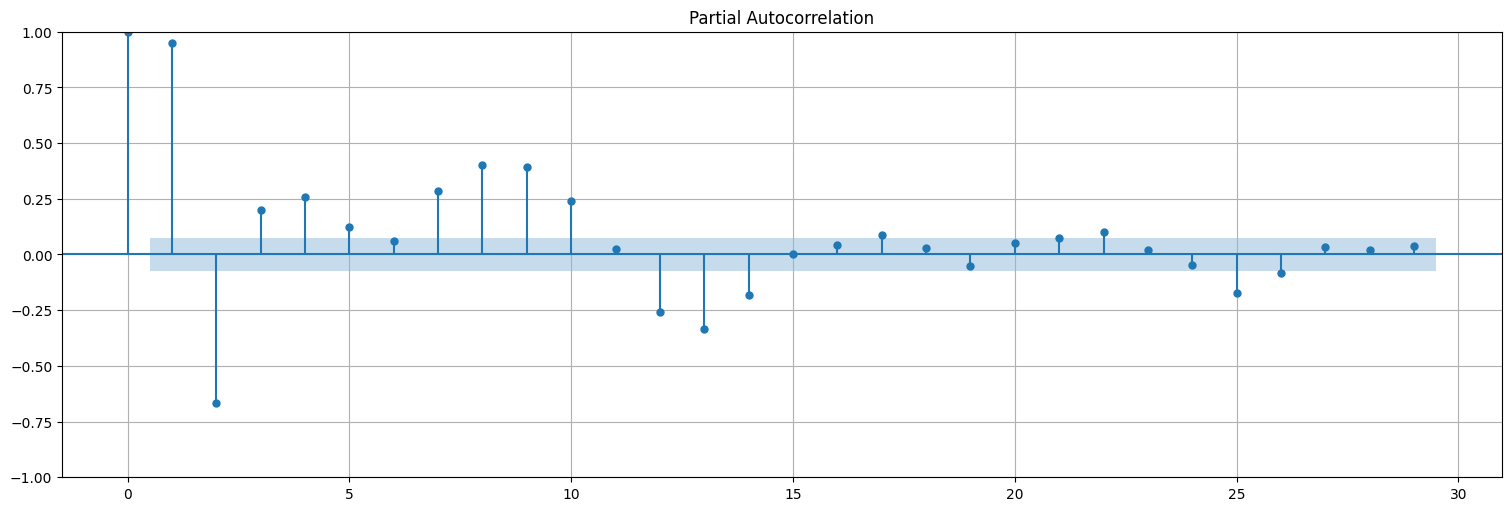

In [12]:
plot_pacf(cardoxfit_linear_resid);

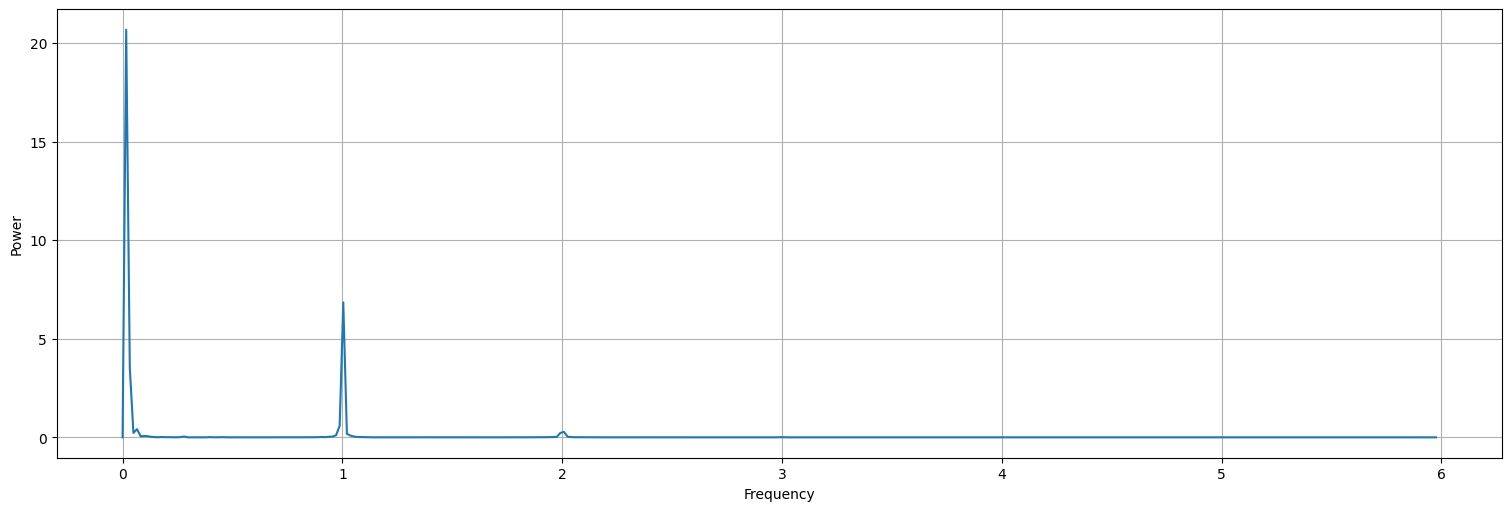

In [13]:
periodogram(cardoxfit_linear_resid,sampling_frequency=12)

In [14]:
spectrum(cardoxfit_linear_resid, sampling_frequency=12)

,Frecuencia,Potencia
0,0.016461,20.690398
1,1.004115,6.850596
2,0.032922,3.510883
3,0.987654,0.587140
4,0.065844,0.415409
5,2.008230,0.276692
6,1.991770,0.225894
7,0.049383,0.224369
8,1.020576,0.177726
9,0.971193,0.103252


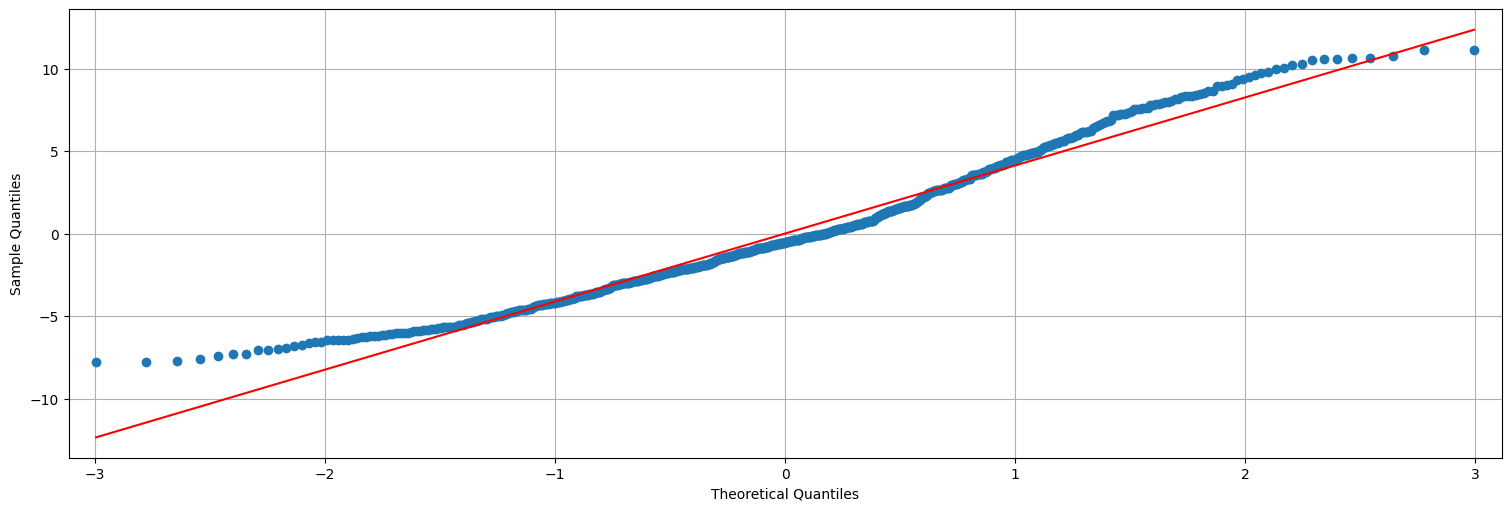

In [15]:
sm.qqplot(cardoxfit_linear_resid, line="s");

Parte 2

In [16]:
time2 = time**2

datos = pd.concat([time, time2, cardox], axis=1)
datos.columns = ["time", "time2", "cardox"]

cardoxfit_linear_cuad = ols(formula="cardox ~ time + time2", data=datos).fit()
cardoxfit_linear_cuad_resid = cardoxfit_linear_cuad.resid
cardoxfit_linear_cuad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 cardox   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 5.591e+04
Date:                Mon, 01 Jul 2024   Prob (F-statistic):               0.00
Time:                        18:11:01   Log-Likelihood:                -1612.8
No. Observations:                 729   AIC:                             3232.
Df Residuals:                     726   BIC:                             3245.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    325.5137      0.120   2718.858      0.000     325.279     325.749
time           0.0903      0.001     90.411      0.000       0.088       0.092
time2       8.787e-05   2.07e-06     42.416      0.000    8.38e-05    9.19e-05
==============================================================================
Omnibus:                      110.611   Durbin-Watson:                   0.308
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.547
Skew:                          -0.092   Prob(JB):                     1.04e-06
Kurtosis:                       2.066   Cond. No.                     2.01e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

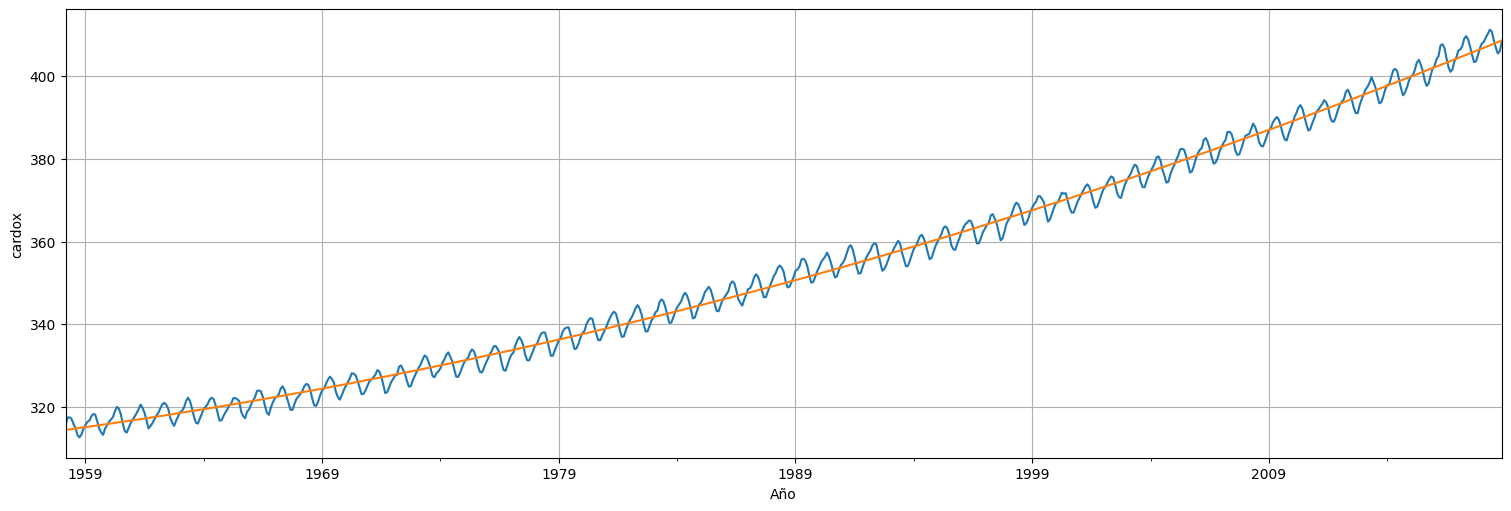

In [17]:
ax = cardox.plot(xlabel="Año", ylabel="cardox", legend=False)
ax.plot(cardoxfit_linear_cuad.fittedvalues);

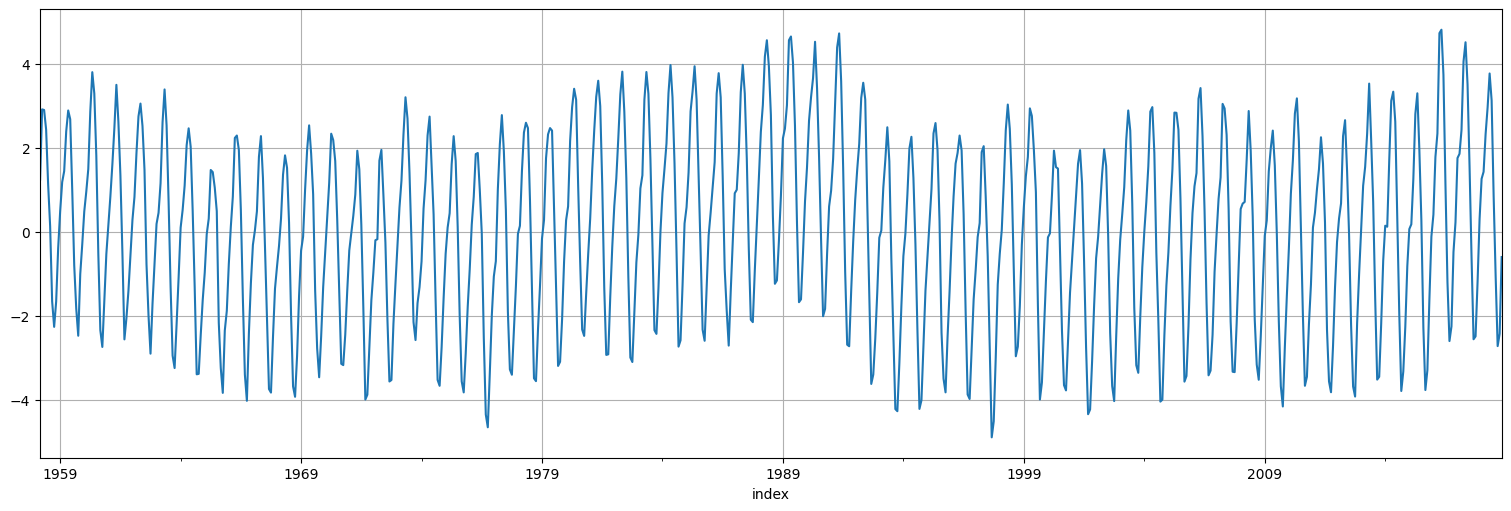

In [18]:
cardoxfit_linear_cuad_resid.plot();

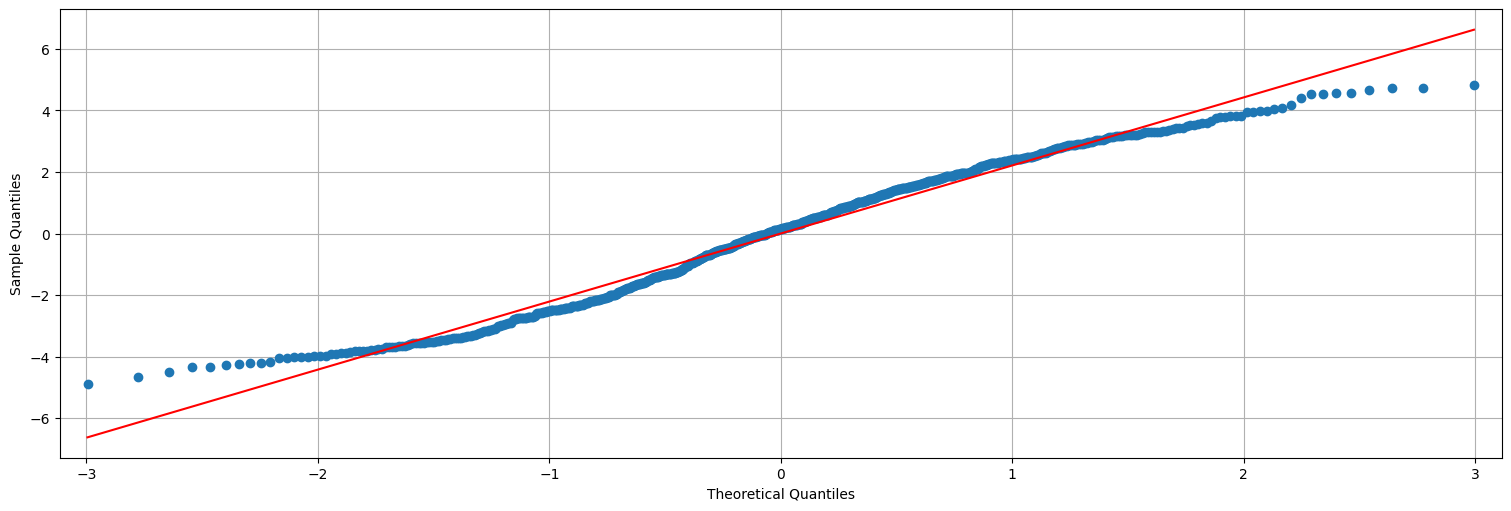

In [24]:
sm.qqplot(cardoxfit_linear_cuad_resid, line='s');

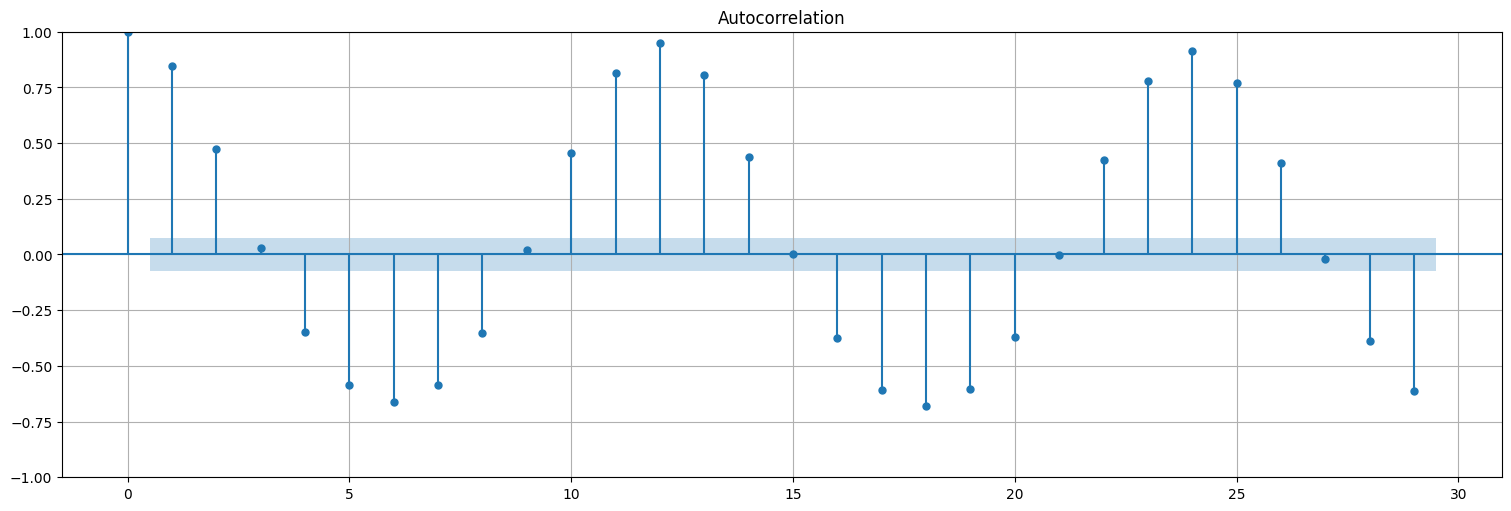

In [19]:
plot_acf(cardoxfit_linear_cuad_resid,bartlett_confint=False);

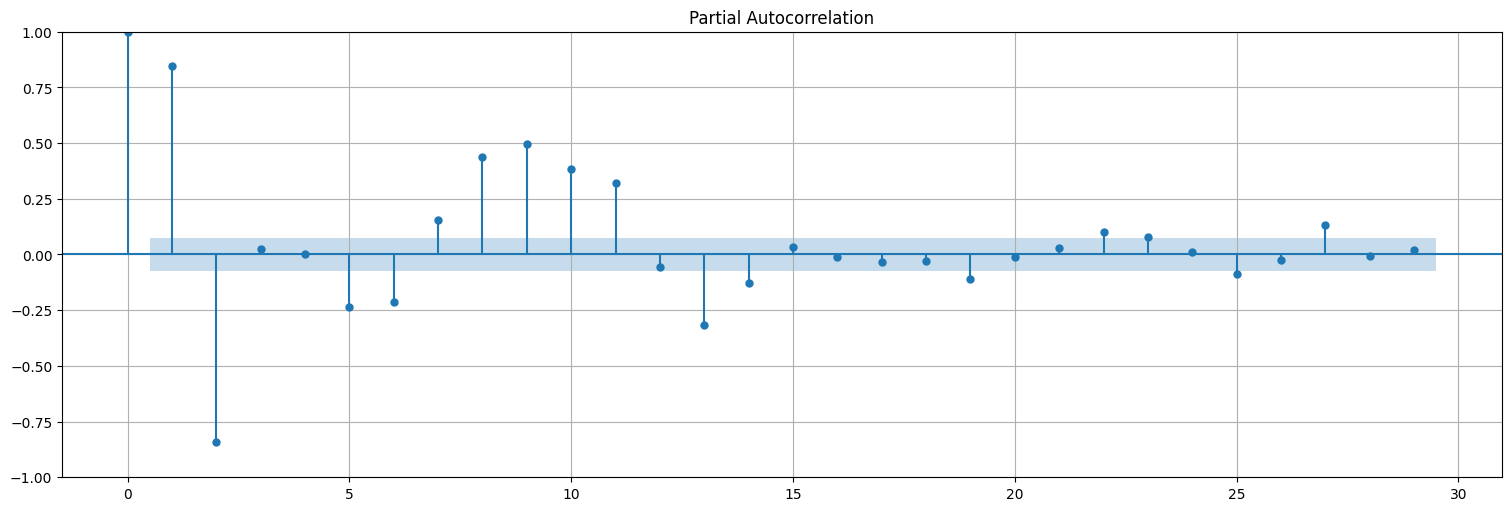

In [20]:
plot_pacf(cardoxfit_linear_cuad_resid);

Parte 3

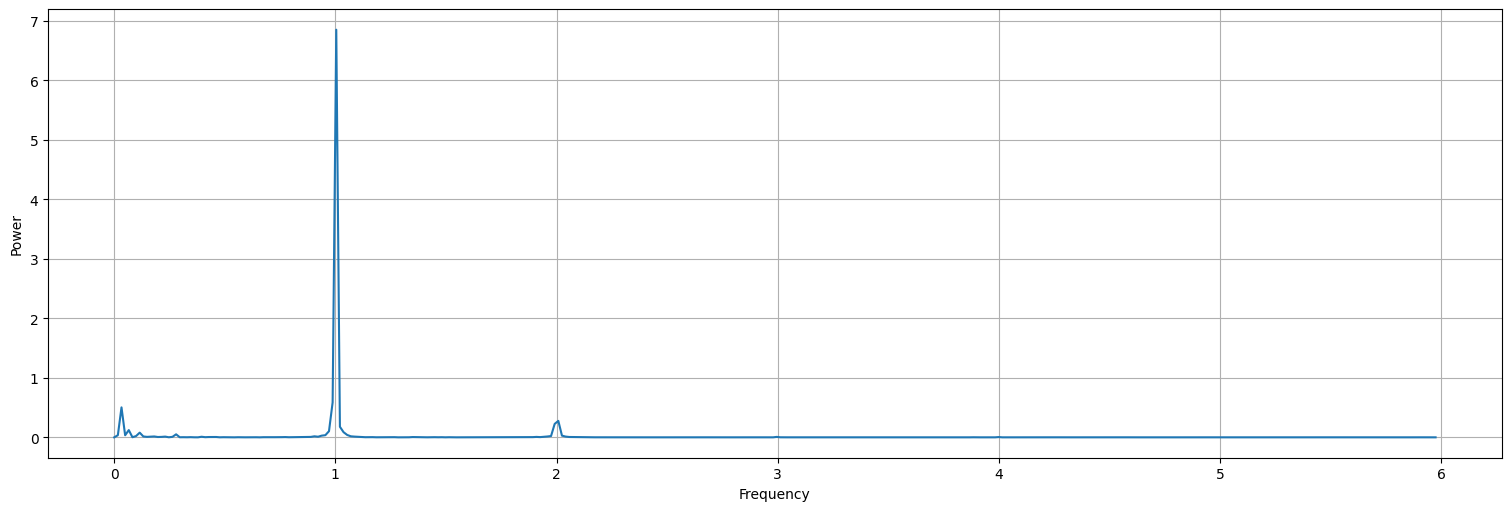

In [21]:
periodogram(cardoxfit_linear_cuad_resid,sampling_frequency=12)

In [22]:
spectrum(cardoxfit_linear_cuad_resid, sampling_frequency=12)

,Frecuencia,Potencia
0,1.004115,6.851430
1,0.987654,0.587196
2,0.032922,0.503610
3,2.008230,0.276524
4,1.991770,0.226001
5,1.020576,0.177790
6,0.065844,0.121813
7,0.971193,0.103334
8,1.037037,0.086701
9,0.115226,0.078760


Parte 4

In [42]:
fit_ar2 = ARIMA(cardox,order=(2,0,0),trend='ct').fit()
fit_ar2_resid = fit_ar2.resid
fit_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  729
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -890.799
Date:                Mon, 01 Jul 2024   AIC                           1791.598
Time:                        19:15:35   BIC                           1814.556
Sample:                    03-31-1958   HQIC                          1800.456
                         - 11-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        306.5787      0.742    412.914      0.000     305.123     308.034
x1             0.1295      0.002     77.932      0.000       0.126       0.133
ar.L1          1.6667      0.027     61.593      0.000       1.614       1.720
ar.L2         -0.7450      0.029    -25.460      0.000      -0.802      -0.688
sigma2         0.6706      0.039     17.107      0.000       0.594       0.747
===================================================================================
Ljung-Box (L1) (Q):                  66.58   Jarque-Bera (JB):                 5.27
Prob(Q):                              0.00   Prob(JB):                         0.07
Heteroskedasticity (H):               1.25   Skew:                             0.16
Prob(H) (two-sided):                  0.08   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

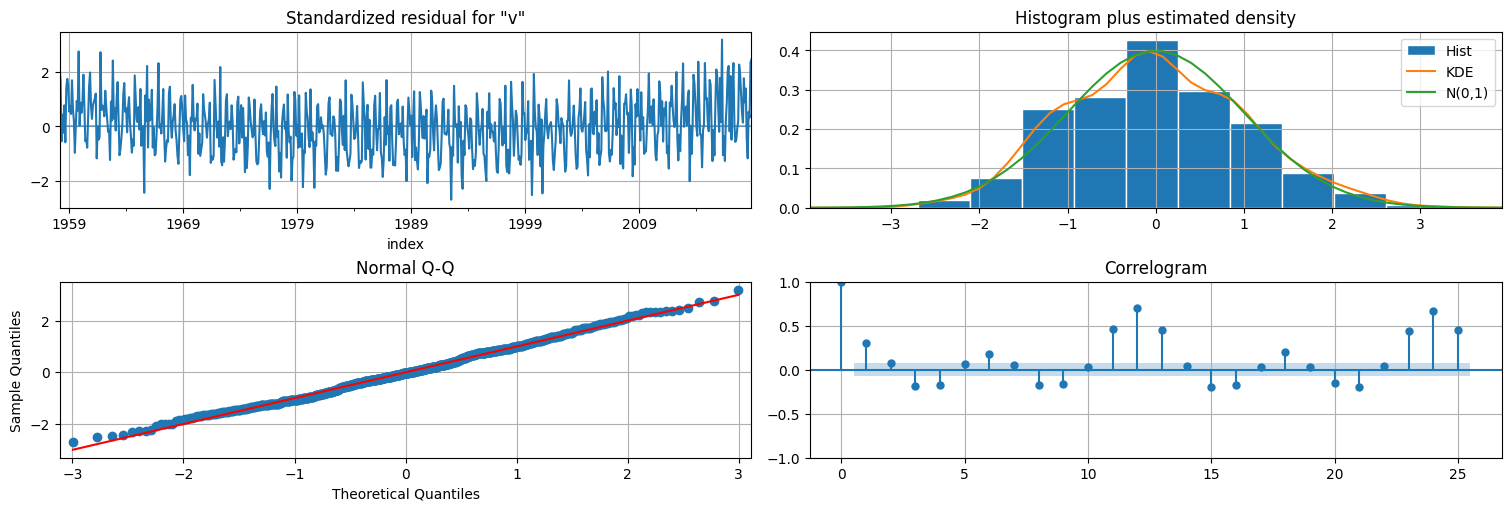

In [36]:
fit_ar2.plot_diagnostics(lags=25);

In [43]:
fit_ar2_i1 = ARIMA(cardox,order=(2,1,0),trend='n').fit()
fit_ar2_i1_resid = fit_ar2_i1.resid
fit_ar2_i1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  729
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -840.180
Date:                Mon, 01 Jul 2024   AIC                           1686.360
Time:                        19:16:16   BIC                           1700.130
Sample:                    03-31-1958   HQIC                          1691.673
                         - 11-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0492      0.039     26.984      0.000       0.973       1.125
ar.L2         -0.4876      0.038    -12.950      0.000      -0.561      -0.414
sigma2         0.5878      0.032     18.193      0.000       0.524       0.651
===================================================================================
Ljung-Box (L1) (Q):                  18.67   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.00   Prob(JB):                         0.97
Heteroskedasticity (H):               1.22   Skew:                            -0.01
Prob(H) (two-sided):                  0.13   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

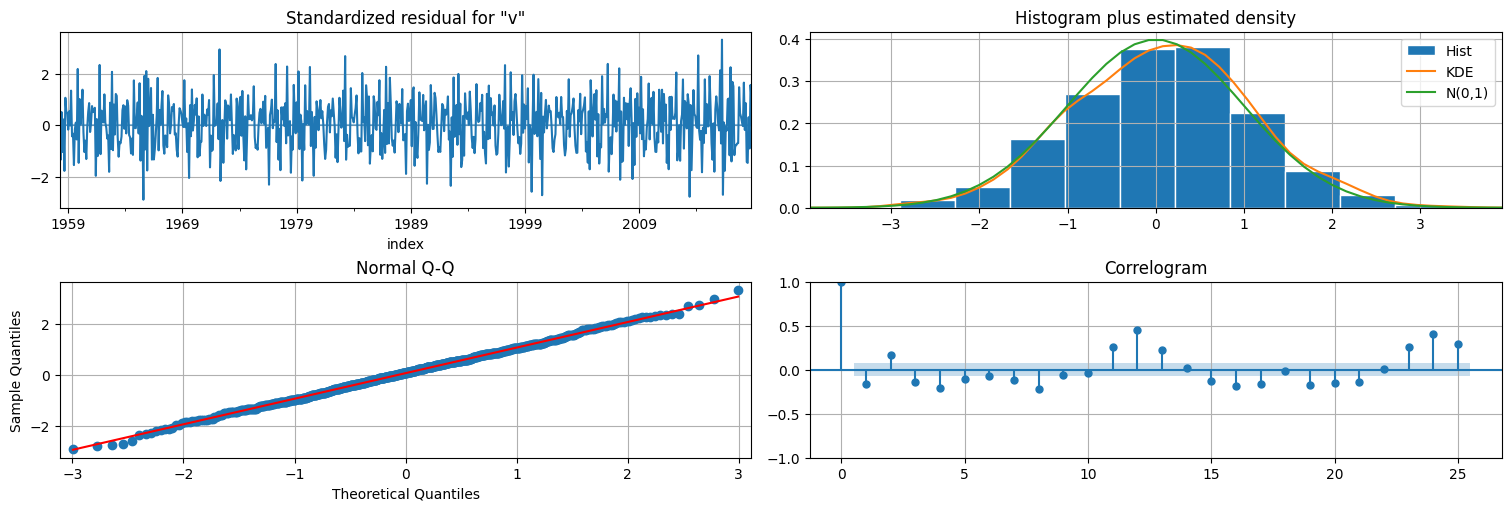

In [44]:
fit_ar2_i1.plot_diagnostics(lags=25);

In [55]:
fit_sarima = ARIMA(cardox,order=(2,1,1), seasonal_order=(2, 1, 1, 12),trend="n").fit()
fit_sarima_resid = fit_sarima.resid
fit_sarima.summary()

c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\guill\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                     
========================================================================================
Dep. Variable:                            value   No. Observations:                  729
Model:             ARIMA(2, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -183.758
Date:                          Mon, 01 Jul 2024   AIC                            381.516
Time:                                  19:25:21   BIC                            413.532
Sample:                              03-31-1958   HQIC                           393.879
                                   - 11-30-2018                                         
Covariance Type:                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2960      0.126      2.344      0.019       0.048       0.544
ar.L2          0.0710      0.069      1.035      0.301      -0.063       0.205
ma.L1         -0.6668      0.123     -5.426      0.000      -0.908      -0.426
ar.S.L12      -0.0086      0.045     -0.188      0.851      -0.098       0.080
ar.S.L24      -0.0355      0.041     -0.868      0.385      -0.116       0.045
ma.S.L12      -0.8570      0.031    -27.926      0.000      -0.917      -0.797
sigma2         0.0955      0.005     20.421      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 4.92
Prob(Q):                              0.84   Prob(JB):                         0.09
Heteroskedasticity (H):               1.16   Skew:                             0.00
Prob(H) (two-sided):                  0.26   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

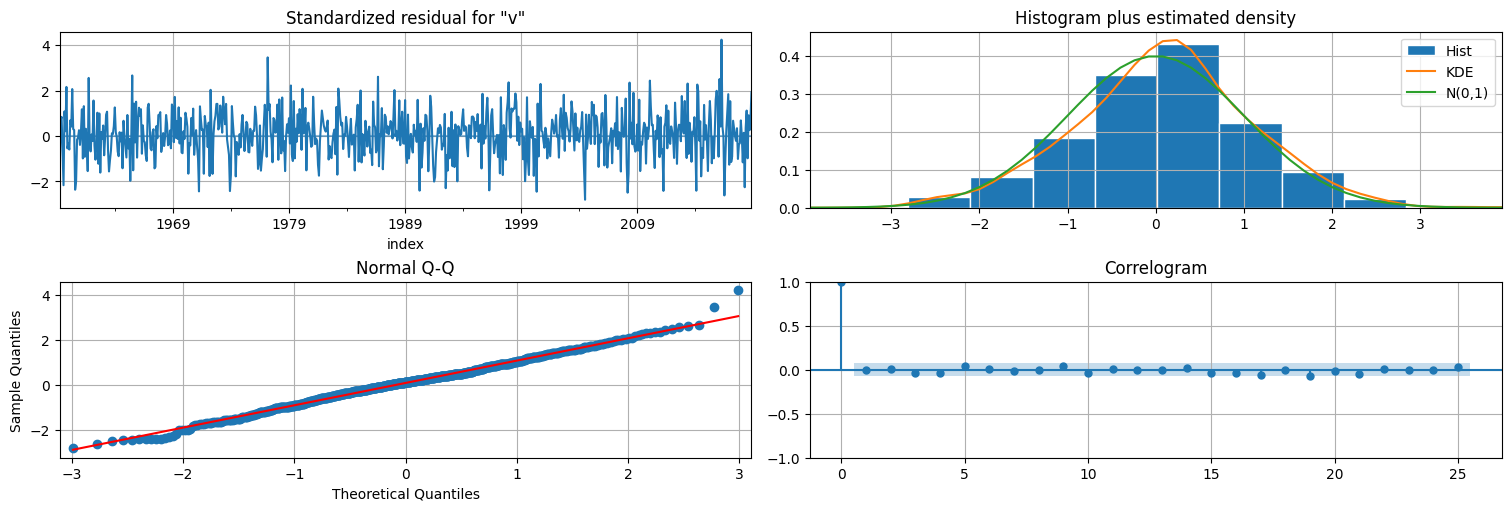

In [56]:
fit_sarima.plot_diagnostics(lags=25);

### Ejercicio 2

Se considera la serie `Nile` incluida con `R` con las medidas anuales de flujo en unidades de $10^8 m^3$ sobre la represa de Asswan.

1. Discutir brevemente si la serie es estacionaria.
2. Realizar un análisis de la autocorrelación y autocorrelación parcial.
3. Realizar un ajuste a un modelo $ARMA(p,q)$ adecuado. Puede incorporar dos modelos para comparar.
4. Analizar los residuos resultantes.
5. Realizar una predicción a 5 años hacia adelante.

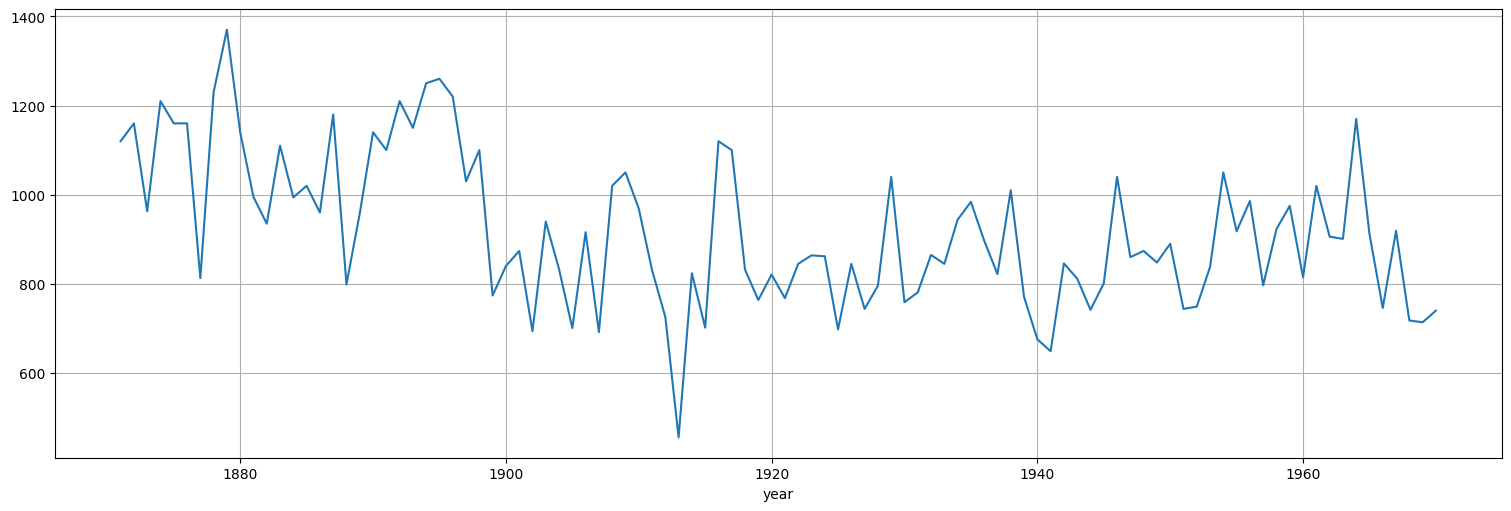

In [26]:
nile = sm.datasets.nile.load()
nile = pd.Series(nile["data"]["volume"].values, index=nile["data"]["year"])
nile.plot();

### Ejercicio 3

Se considera la serie $x$ de niveles de $CO$, así como la serie $y$ de mortalidad semanal por causas respiratorias. Ambas son parte del objeto `lap` de la biblioteca `astsa`. Ambas series comienzan en $1970$ y tienen una frecuencia semanal (`freq=52`).

1. Analice la correlación cruzada entre ambas series.
2. ¿Para que valor de lag se da la mayor correlación entre ambas?
3. Se propone un modelo de la forma $y_t = \beta_0 + \beta_1 x_{t-l} + w_t$ con $x$ e $y$ como antes y $l$ el lag de la parte anterior. Realice un ajuste lineal para estimar los parámetros $\beta_0$ y $\beta_1$.
4. ¿Cuánto de la varianza de la serie original se explica por la relación entre $x$ e $y$?
5. Realice un gráfico de la predicción del modelo (no olvide que la primera predicción será luego de $l$ lags) y la mortalidad observada. 
6. Analice los residuos del modelo y discuta si aún queda información por ajustar.

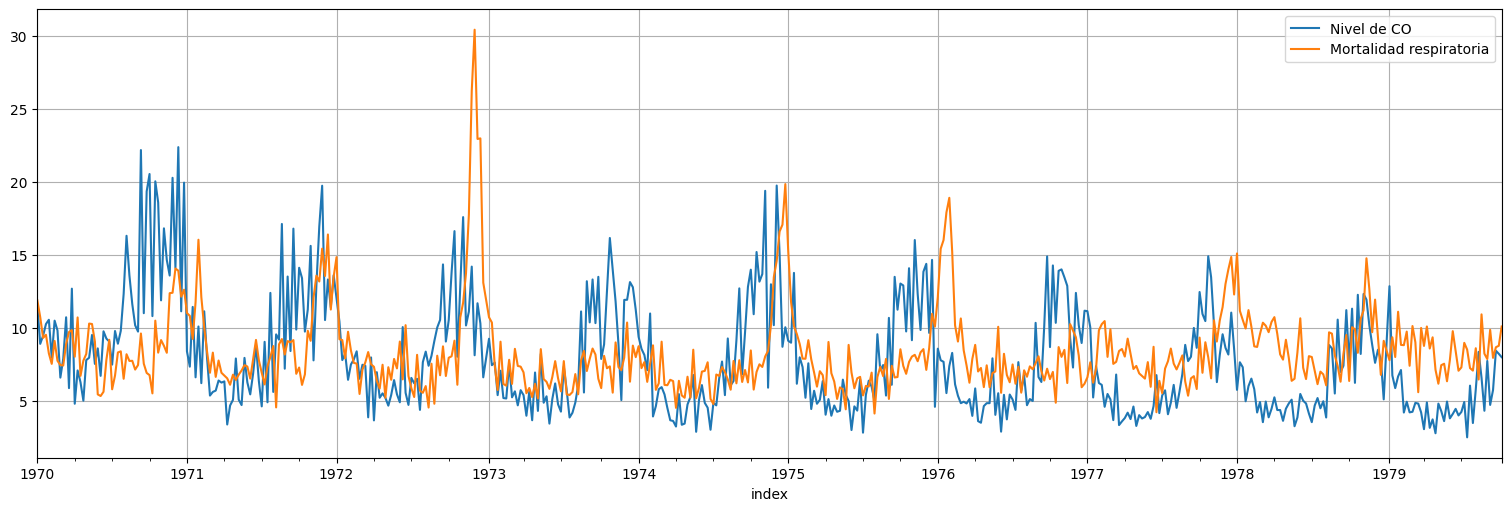

In [29]:
x = astsa.lap["co"]
y = astsa.lap["rmort"]

x.plot(label="Nivel de CO");
y.plot(label="Mortalidad respiratoria");
plt.legend();